In [1]:
import pandas as pd
import numpy as np
import geopandas
from scipy.spatial import ConvexHull, Delaunay
from sklearn.cluster import KMeans

import requests
import time
from tqdm import tqdm

import matplotlib.pyplot as plt
import folium

import warnings
warnings.filterwarnings('ignore')

In [2]:
# LOAD CODE BASE
post_codes = pd.read_excel('post_codes.xlsx')

In [3]:
# UPLOAD FROM OSRM CENTER GEOLOCATION OF POSTAL CODE
"""codes_base_list = pd.read_excel('codes_base.xlsx')

codes_data = []

with tqdm(total=len(post_codes['Kod pocztowy'])) as bar:
    for code in post_codes['Kod pocztowy']:
        if code not in list(codes_base_list['postal code'].unique()):
            try:
                link = f"https://nominatim.openstreetmap.org/search?q={code}&format=json&polygon_kml=1&addressdetails=1"
                geo = requests.get(link, verify=False)
                code_parameters = pd.DataFrame(geo.json())[['name','lat','lon']].rename(columns={'name':'postal code'})
                time.sleep(1)
                codes_data.append(code_parameters)
            except:
                empty_code = pd.DataFrame(data=[[code, np.nan, np.nan]], columns = ['postal code','lat','lon'])
                codes_data.append(empty_code)
                time.sleep(1)
            bar.update(1)
        
codes_data = pd.concat(codes_data)

codes_data = pd.concat([codes_base_list, codes_data])

codes_data.to_excel('codes_base.xlsx', index=False)"""

'codes_base_list = pd.read_excel(\'codes_base.xlsx\')\n\ncodes_data = []\n\nwith tqdm(total=len(post_codes[\'Kod pocztowy\'])) as bar:\n    for code in post_codes[\'Kod pocztowy\']:\n        if code not in list(codes_base_list[\'postal code\'].unique()):\n            try:\n                link = f"https://nominatim.openstreetmap.org/search?q={code}&format=json&polygon_kml=1&addressdetails=1"\n                geo = requests.get(link, verify=False)\n                code_parameters = pd.DataFrame(geo.json())[[\'name\',\'lat\',\'lon\']].rename(columns={\'name\':\'postal code\'})\n                time.sleep(1)\n                codes_data.append(code_parameters)\n            except:\n                empty_code = pd.DataFrame(data=[[code, np.nan, np.nan]], columns = [\'postal code\',\'lat\',\'lon\'])\n                codes_data.append(empty_code)\n                time.sleep(1)\n            bar.update(1)\n        \ncodes_data = pd.concat(codes_data)\n\ncodes_data = pd.concat([codes_base_list, 

In [4]:
# UPLOAD GEOLOCATION OF GIVEN CITIES
cities = ['Warszawa','Lublin','Wrocław' ]

cities_data = []

with tqdm(total=len(cities)) as bar:
    for city in cities:
        try:
            link = f"https://nominatim.openstreetmap.org/search?q={city}&format=json&polygon_kml=1&addressdetails=1"
            geo = requests.get(link, verify=False)
            code_parameters = pd.DataFrame(geo.json())[['name','lat','lon']].rename(columns={'name':'city'})
            time.sleep(1)
            cities_data.append(code_parameters)
        except:
            empty_code = pd.DataFrame(data=[[city, np.nan, np.nan]], columns = ['city','lat','lon'])
            codes_data.append(empty_code)
            time.sleep(1)
        bar.update(1)
        
cities_data = pd.concat(cities_data).drop_duplicates(subset='city')

cities_data

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.35s/it]


,city,lat,lon
0,Warszawa,52.2337172,21.071432235636493
0,Lublin,51.218194499999996,22.554677562145155
0,Wrocław,51.1263106,16.97819633051261


In [5]:
# CREATE CODE GROUPS
codes_data = pd.read_excel('codes_base.xlsx').dropna()
codes_data['code group'] = codes_data['postal code'].apply(lambda x: str(x)[:4])
codes_data.head()

,postal code,lat,lon,code group
0,00-001,52.229852,21.006525,00-0
1,00-004,52.235602,21.008997,00-0
2,00-008,52.234537,21.009550,00-0
3,00-009,52.234699,21.010639,00-0
4,00-012,52.233598,21.011262,00-0


In [6]:
# CALCULATE CENTER OF GROUP AS MEAN OF MAX AND MIN GEOLOCATION
codes_data = codes_data.assign(lat_min = codes_data['lat'],lat_max = codes_data['lat'],
                              lon_min = codes_data['lon'], lon_max = codes_data['lon'])

group_codes_data = codes_data[['code group','lat_min','lat_max','lon_min','lon_max']]\
            .groupby(['code group'])\
            .agg({'lat_min':'min', 'lat_max':'max', 'lon_min':'min', 'lon_max':'max'})
group_codes_data = group_codes_data.assign(group_lat = (group_codes_data['lat_min']+group_codes_data['lat_max'])/2,
                                          group_lon = (group_codes_data['lon_min']+group_codes_data['lon_max'])/2)\
                                    .reset_index()\
                                    .drop(columns=['lat_min', 'lat_max', 'lon_min', 'lon_max'])
group_codes_data.head()

,code group,group_lat,group_lon
0,00-0,52.238210,21.011439
1,00-1,52.017763,20.995951
2,00-2,52.252114,21.005576
3,00-3,52.239691,21.024281
4,00-4,52.223751,21.034269


In [7]:
# CALCULATE SHAPE OF CODE GROUP BY GENERATE POLYGON FROM CENTERS OF POSTAL CODES USING CONVEX_HULL METHOD

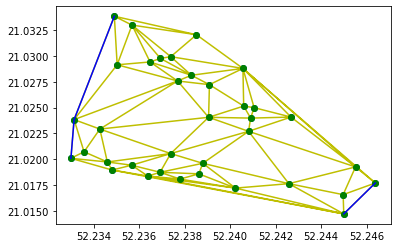

In [8]:
# TEST OF METHOD ON ONE GROUP
points = np.array(codes_data.loc[codes_data['code group']=='00-3'][['lat','lon']])
# shape calculation
hull = ConvexHull(points)
hull_points = hull.simplices
# method calculation
simplices = Delaunay(points).simplices
# graph with results
plt.scatter(points[:,0], points[:,1])
plt.triplot(points[:, 0], points[:, 1], simplices, color='y')
plt.scatter(points[:, 0], points[:, 1], color='g')
# polygon shape
polygon_shape = [[points[x,0], points[x,1]] for x in hull_points]

for simplex in hull_points[:3]:
    plt.plot(points[simplex,0], points[simplex,1], 'k-', color='b')

In [9]:
# FUNCTION FOR CALCULATE POLYGON
def calculate_polygon(group):
    # filter data
    points = np.array(codes_data.loc[codes_data['code group']==group][['lat','lon']])
    if points.shape[0]>2:
        # shape calculation
        hull = ConvexHull(points)
        hull_points = hull.simplices
        # return polygon shape
        polygon_shape = [[points[x,0], points[x,1]] for x in hull_points]
    else:
        # if can`t calculate return points
        polygon_shape = points
    return polygon_shape

In [10]:
# CALCULATE SHAPE FOR EACH CODES GROUP
group_codes_data['shape'] = group_codes_data['code group'].apply(lambda x: calculate_polygon(x))

In [11]:
# PREPARE DATA FOR RANGES CALCULATION IN GEOPANDAS

# prepare groups
group_codes_data = (geopandas.GeoDataFrame(
    group_codes_data, 
    geometry=geopandas.points_from_xy(group_codes_data['group_lon'], group_codes_data['group_lat']), 
    crs='EPSG:4258'
))

# range in meters
distance_limit = 150000  # w metrach
# prepare cities
cities_data = (geopandas
                .GeoDataFrame(
                    cities_data, 
                    geometry=geopandas.points_from_xy(cities_data['lon'], cities_data['lat']), 
                    crs='EPSG:4258')
                .assign(**{f'geometry_buffer_{distance_limit}': lambda x: x.to_crs('EPSG:3328').geometry.buffer(distance_limit).to_crs('EPSG:4258')})
                .set_geometry(f'geometry_buffer_{distance_limit}')
               )

In [12]:
# JOIN ALL CODES GROUP IN DEFINED DISTANCE LIMIT
cities_with_groups = geopandas.sjoin(
    cities_data,        # cities
    group_codes_data,   # grouped codes
    how = 'left',       # to each city
    op = 'contains'     # join codes in defined range
)

In [13]:
#def prepare_data_for_location(city):
#    city_groups = cities_with_groups.loc[cities_with_groups['city']==city]['code group'].unique()
#    city_group_for_map = group_codes_data.copy()
#    city_group_for_map['zone'] = city_group_for_map['code group'].apply(lambda x: 'A' if x in city_groups else 'B')
#    return city_group_for_map

def normalize_name(city):
    dictionary = {'Ą':'A', 'Ć':'C', 'Ę':'E', 'Ł':'L', 'Ń':'N', 'Ó':'O', 'Ś':'S', 'Ź':'Z', 'Ż':'Z',
             'ą':'a', 'ć':'c', 'ę':'e', 'ł':'l', 'ń':'n', 'ó':'o', 'ś':'s', 'ź':'z', 'ż':'z'}
    for letter in city:
        try:
            city = city.replace(letter, dictionary[letter])
        except:
            pass
    return city

In [14]:
cities_with_groups.head(2)

,city,lat,lon,geometry,geometry_buffer_150000,index_right,code group,group_lat,group_lon,shape
0,Warszawa,52.2337172,21.071432235636493,POINT (21.07143 52.23372),"POLYGON ((22.41891 52.23372, 22.41242 52.15255...",149,21-4,51.840102,22.251674,"[[[51.9891759452765, 51.69102799436796], [22.5..."
0,Warszawa,52.2337172,21.071432235636493,POINT (21.07143 52.23372),"POLYGON ((22.41891 52.23372, 22.41242 52.15255...",67,08-1,52.186464,22.268224,"[[[52.2856871999187, 52.3659023858156], [22.61..."


In [15]:
# LETS FIND ANOTHER CENTER IN WESTERN POLAND

# prepare data with codes for clustering
clustering_data = group_codes_data[['group_lat','group_lon']].drop_duplicates()

# coordinates for initiate new center
new_center = [51.90,14.7]

# create centroids df for k_means
centers = cities_data[['city','lat','lon']]
centers.loc[-1] = ['NEW_CENTER',new_center[0],new_center[1]]
centers

,city,lat,lon
0,Warszawa,52.2337172,21.071432235636493
0,Lublin,51.218194499999996,22.554677562145155
0,Wrocław,51.1263106,16.97819633051261
-1,NEW_CENTER,51.9,14.7


In [16]:
# number of iterations
iterations = 10

# path of NEW CENTER
new_center_route = []

for i in range(iterations):
    # add step to path
    new_center_route.append(pd.DataFrame(centers.loc[-1]).T)
    # prepare k_means engine
    kmeans_step = KMeans(n_clusters=centers.shape[0],       
                    init=np.array(centers[['lat','lon']]),            
                    n_init=10,                             
                    max_iter=1,                            
                    copy_x=True)
    # clustering step for finding centers
    labels = kmeans_step.fit_predict(clustering_data)
    labels_result = pd.DataFrame(kmeans_step.cluster_centers_, columns=['Lat','Lon'])
    # change finding center data in df and restore base centers
    centers.loc[-1] = ['NEW_CENTER',labels_result.iloc[-1]['Lat'],labels_result.iloc[-1]['Lon']]


In [17]:
# create data frame with path of new center in calculating process
new_center_route = pd.concat(new_center_route)

In [18]:
new_center_route

,city,lat,lon
-1,NEW_CENTER,51.9,14.7
-1,NEW_CENTER,53.014502,15.282786
-1,NEW_CENTER,53.211968,15.666765
-1,NEW_CENTER,53.433035,16.242549
-1,NEW_CENTER,53.406887,16.575404
-1,NEW_CENTER,53.44678,16.790974
-1,NEW_CENTER,53.45979,16.820251
-1,NEW_CENTER,53.45979,16.820251
-1,NEW_CENTER,53.45979,16.820251
-1,NEW_CENTER,53.45979,16.820251


In [19]:
# PREPARE DATA FOR RANGES CALCULATION IN GEOPANDAS
new_center = pd.DataFrame(centers.loc[-1]).T
# prepare cities
new_center_data = (geopandas
                .GeoDataFrame(
                    new_center, 
                    geometry=geopandas.points_from_xy(new_center['lon'], new_center['lat']), 
                    crs='EPSG:4258')
                .assign(**{f'geometry_buffer_{distance_limit}': lambda x: x.to_crs('EPSG:3328').geometry.buffer(distance_limit).to_crs('EPSG:4258')})
                .set_geometry(f'geometry_buffer_{distance_limit}')
               )

# JOIN ALL CODES GROUP IN DEFINED DISTANCE LIMIT
new_center_data = geopandas.sjoin(
    new_center_data,        # cities
    group_codes_data,   # grouped codes
    how = 'left',       # to each city
    op = 'contains'     # join codes in defined range
)

In [20]:
# SHOW RESULTS ON MAP
colors = {0: "darkblue", 1: 'pink', 2: "orange", 3:"gray", 4: "red", 5: "green", 6: 'blue', 
        7:'darkgreen', 8:'white', 9:'purple', 10:'darkpurple', 11: 'beige', 12: 'yellow'}

created_map = folium.Map(location=[51.78,19.45], zoom_start=6)

results = []

# create city layer on map
city_layer = folium.FeatureGroup(name='CITIES', col= 'black', show=False).add_to(created_map)

# for each city:
for city in cities:
    # add city marker
    #city_name = cities_data.loc[cities_data['city']==city]['city'][0]    
    city_marker = folium.Marker(
        [cities_data.loc[cities_data['city']==city]['lat'][0], cities_data.loc[cities_data['city']==city]['lon'][0]], 
        tooltip = normalize_name(city), icon = folium.Icon(color = colors[5]))
    city_layer.add_child(city_marker)

# create city layer on map
heighborhood_layer = folium.FeatureGroup(name='HEIGHBORHOOD', col= 'black', show=False).add_to(created_map)

# prepade codes data from heighborhood
for _, row in cities_with_groups.iterrows():
    try:
        shape_data = row['shape']
        polygon_shape = []
        for l in shape_data:
            polygon_shape.append([l[0][0], l[1][0]])
            polygon_shape.append([l[0][1], l[1][1]])

        code_polygon = folium.Polygon(polygon_shape, 
                                      color = colors[5], weight=7, fill=True, fill_color=colors[5],
                                      tooltip = row['code group'])
        heighborhood_layer.add_child(code_polygon)
    except:
        pass

# ADD TO MAP NEW CENTER WITH CODES AND CALCULATION ROUTE
new_center_layer = folium.FeatureGroup(name='NEW CENTER', col= 'black', show=False).add_to(created_map)

city_marker = folium.Marker(
    [float(new_center['lat']), float(new_center['lon'])], 
    tooltip = normalize_name('NEW CENTER'), icon = folium.Icon(color = colors[2]))
new_center_layer.add_child(city_marker)

# prepade codes data from heighborhood
for _, row in new_center_data.iterrows():
    try:
        shape_data = row['shape']
        polygon_shape = []
        for l in shape_data:
            polygon_shape.append([l[0][0], l[1][0]])
            polygon_shape.append([l[0][1], l[1][1]])

        code_polygon = folium.Polygon(polygon_shape, 
                                      color = colors[2], weight=7, fill=True, fill_color=colors[2],
                                      tooltip = row['code group'])
        new_center_layer.add_child(code_polygon)
    except:
        pass

# add new center path
new_center_route = np.array(new_center_route[['lat','lon']])
route = folium.PolyLine(new_center_route,         
                color="red",         
                weight=7,            
                tooltip = 'NEW CENTER ROUTE',     
                smooth_factor = 0.1  )
new_center_layer.add_child(route)

# create codes layer on map
codes_layer = folium.FeatureGroup(name='CODES', col= 'black', show=True).add_to(created_map)
# prepade codes data from all data
for _, row in group_codes_data.iterrows():
    try:
        shape_data = row['shape']
        polygon_shape = []
        for l in shape_data:
            polygon_shape.append([l[0][0], l[1][0]])
            polygon_shape.append([l[0][1], l[1][1]])

        code_polygon = folium.Polygon(polygon_shape, 
                                      color = colors[3], weight=7, fill=True, fill_color=colors[3],
                                      tooltip = row['code group'])
        codes_layer.add_child(code_polygon)
    except:
        pass
    
# add menu   
folium.map.LayerControl('topleft', collapsed= False).add_to(created_map)

created_map

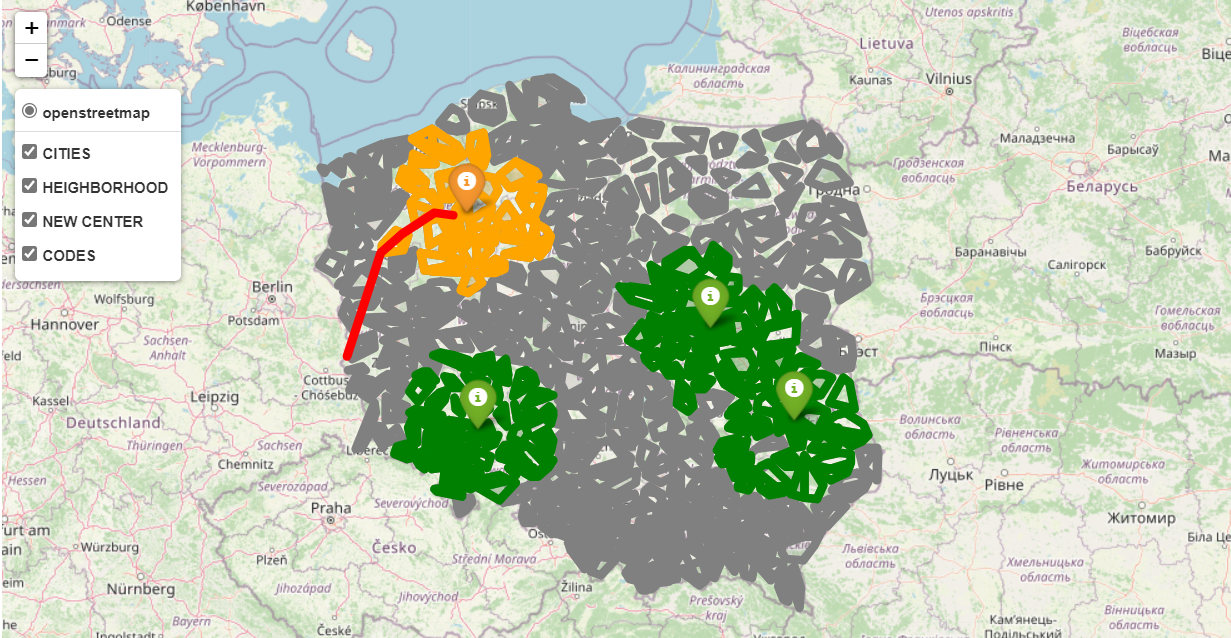